This notebook is used to create simple plots that do not require us running code from a repository with certain dependencies

### Scaffold split partitions

In [ ]:
import os
from math import floor

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import numpy as np

from rdkit.Chem.Scaffolds import MurckoScaffold

def generate_scaffold(smiles, include_chirality=False):
    """ Obtain Bemis-Murcko scaffold from smiles
    :return: smiles of scaffold """
    scaffold = MurckoScaffold.MurckoScaffoldSmiles(
        smiles=smiles, includeChirality=include_chirality)
    return scaffold

task_name = "qm9"
path_to_smiles = f"./Uni-Mol/unimol/data/molecular_property_prediction/raw_data/{task_name}.csv"

smiles_list = pd.read_csv(path_to_smiles)["smiles"].to_list()

all_scaffolds = {}
for i, smiles in enumerate(smiles_list):
    scaffold = generate_scaffold(smiles, include_chirality=True)
    if scaffold not in all_scaffolds:
        all_scaffolds[scaffold] = [i]
    else:
        all_scaffolds[scaffold].append(i)

# sort from largest to smallest sets
all_scaffolds = {key: sorted(value) for key, value in all_scaffolds.items()}
all_scaffold_sets = [
    scaffold_set for (scaffold, scaffold_set) in sorted(
        all_scaffolds.items(), key=lambda x: (len(x[1]), x[1][0]), reverse=True)
]

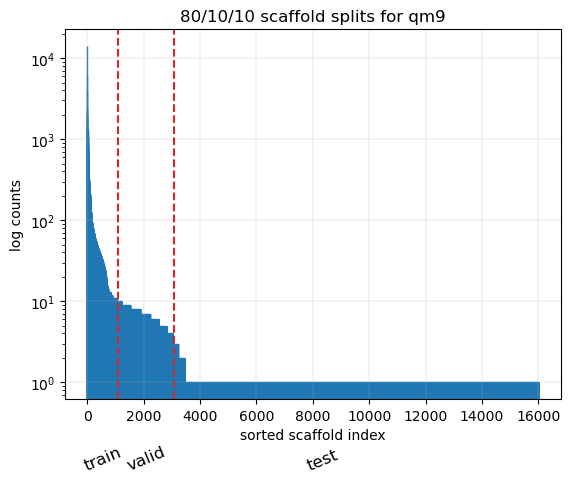

In [138]:
scaffold_bins = list(np.concatenate([[i for a in scaffold_set] for i, scaffold_set in enumerate(all_scaffold_sets)]))

counts, bin_edges, _ = plt.hist(scaffold_bins, bins=len(all_scaffolds), log=True, edgecolor='#1f77b4')

train_cutoff = np.where(np.cumsum(counts) > floor(0.8 * len(scaffold_bins)))[0][0]
valid_cutoff = np.where(np.cumsum(counts) > floor(0.9 * len(scaffold_bins)))[0][0]
train_line = bin_edges[train_cutoff]
valid_line = bin_edges[valid_cutoff]

plt.axvline(train_line, color="#d62728", ls="--")
plt.axvline(valid_line, color="#d62728", ls="--")
plt.grid(True, which="major", linewidth=0.2)

# Compute text locations
x_train = train_line/2
x_valid = (train_line + valid_line) / 2
x_test = (4*(train_line + valid_line)) / 2

# Create a blended transform:
ax = plt.gca()
transform = transforms.blended_transform_factory(ax.transData, ax.transAxes)

# Place text
plt.text(x_train, -0.2, "train", transform=transform, ha="center",  va="bottom",  fontsize=12, rotation = 45/2)
plt.text(x_valid, -0.2, "valid", transform=transform, ha="center",  va="bottom",  fontsize=12, rotation = 45/2)
plt.text(x_test, -0.2, "test", transform=transform, ha="center",  va="bottom",  fontsize=12, rotation = 45/2)

plt.title(f"80/10/10 scaffold splits for {task_name}")
plt.ylabel("log counts")
plt.xlabel("sorted scaffold index")

plt.show()